# ANOVA of Composition

In [1]:
from Bio.Seq import Seq
# from Bio.Alphabet import generic_dna 
import pandas as pd
import numpy as np
import itertools
import re
import matplotlib.pyplot as plt
from collections import defaultdict 
import scipy
from scipy import stats
import glob
import warnings
warnings.filterwarnings('ignore')
import os
import operator
# import logomaker
import matplotlib
import statsmodels
# from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle
import matplotlib.patches as mpatches
from localcider.sequenceParameters import SequenceParameters
import localcider
from statsmodels.formula.api import ols
# import statsmodels.api as sm
# lowess = sm.nonparametric.lowess
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
lightblue , darkblue, lightgreen, darkgreen, pink =  '#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99'
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### load the data

In [3]:
Folder = '20241105_ANOVA/'

if (os.path.isdir('Figures/')):
    print( 'Figures folder exists')
else:
    os.mkdir('Figures')
if (os.path.isdir('Figures/'+Folder)):
    print( 'Today I will save files in Figures/%s' %Folder)
else:
    os.mkdir('Figures/'+Folder)
    os.mkdir('Figures/'+Folder+'/Logos')
    os.mkdir('Figures/'+Folder+'/SequenceLists')
    os.mkdir('Figures/'+Folder+'/BarGraphs')
    os.mkdir('Figures/'+Folder+'/LineGraphs')
if (os.path.isdir('SimulationSequenceLists/')):
    print( 'folder exists')
else:    
    os.mkdir('SimulationSequenceLists')

    
    
## load data frames
# masterDF   =pd.read_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20210729_withSeqFeatures.csv')
masterDF   =pd.read_csv('../Data/Processed/SC_Glucose_Ratio_MasterDF_20240930_withSeqFeatures.csv')
# WTDF = pd.read_pickle('pickleFiles/MSS18_WTDF_afterProcessingStep2_20210722')
## variables
Activity = 'Activity_SCglucose'
# StdDev  ='Activity_SEM_MSS18'
ActivityThreshold = 100000

#use only the measured data in this analysis:
masterDF = masterDF[masterDF[Activity]>0 ]



# Useful plotting variables
maxActivity = max(masterDF[Activity])*1.1
minActivity = min(masterDF[Activity])*.9

## support variables
# ADlist = [ 'CITED2_N','Hif1-AD2_46','vp16N_C','stat3','p65']
# cited, hif1a,vp16,stat3,p65 = ADlist
# ExtendedADlist = [ 'CITED2_N','Hif1-AD2_46','vp16N_C','stat3','p65','p65_L2Y']
# ADCoordinates={ 'CITED2_N':[220,258],# isoform 1
#                'Hif1-AD2_46':[781,896],# isoform 1
#                'vp16N_C':[415,453], #from blast
#                'stat3':[719,764],# isoform 1
#                'p65':[521,551]}# isoform 1
# ## WT support dictionaries
# WTname2seqDict,WTseq2nameDict,WTname2ActivityDict,WTname2StdDevDict = pickle.load(open('../Analysis/pickleFiles/WTDictionaries','r'))

allAAs = ['A', 'C', 'D', 'E', 'F', 'G', 'H','I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']



Figures folder exists
folder exists


In [4]:
masterDF.columns

Index(['Unnamed: 0', 'ADseq', 'Name', 'ArrayDNA', 'Activity_BioRepA_BYS4',
       'Activity_BioRepB_BYS4', 'TotalReads_BioRepA_BYS4',
       'TotalReads_BioRepB_BYS4', 'BioRep_A_GFP_TotalReads', 'BioRep_A_GFP',
       'BioRep_B_GFP_TotalReads', 'BioRep_B_GFP',
       'BioRep_A_mCherry_TotalReads', 'BioRep_A_mCherry',
       'BioRep_B_mCherry_TotalReads', 'BioRep_B_mCherry',
       'Activity_BYS4_BioRepAverage', 'Stdev_BYS4_BioReps',
       'Activity_SCglucose', '(20703, 'Name')', '(20707, 'Name')', 'Start',
       'Recovered', 'Charge', 'HydrophobicityKD', 'HydrophobicityWW', 'Kappa',
       'Omega', 'OmegaWFY_DE', 'OmegaWFYL_DE', 'OmegaWF_D', 'Disorder', 'A',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
       'S', 'T', 'V', 'W', 'Y', 'Aromatics', 'WFYL', 'W..LF',
       '[WFYL]..[WFYL][WFYL]', '[WFL]..[WFL][WFL]', '[DE][WFY]', '[DE][WF]',
       '[DE][L]', '[DE].[WFY]', '[DE]..[WFY]', 'FF', 'F.F', 'F..F',
       '[FY].....[FY]DF', 'D.F', 'D..F', 'FD', 

In [5]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

In [6]:
ListofExperiments = ['SC Glucose']

ListofExperiments_Activity = ['Activity_SCglucose']


In [7]:
dataCols = ['Charge','WFYL','A', 'C', 'D', 'E', 'F', 'G', 'H','I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# generate string for the statistics model/formula
formula = 'StackedActivityValues ~ '
for col in dataCols:
    formula = formula+col+' + '


ANOVA_DF = masterDF[[Activity,'ADseq','Name']]

# add back the data from other columns
tempSeries = ANOVA_DF.ADseq
Cols2Add = dataCols
for col in Cols2Add:
    tempDict = dict(zip(masterDF.ADseq,masterDF[col]))
    ANOVA_DF[col] = tempSeries.map(tempDict)

# for all ADs
# formula = 'Activity_SCglucose ~ D + E + K+ R + L + F + W + Y+ A + M + P + G '
# formula = 'Activity_SCglucose ~ D + E + R  + L +  W +  A + M + P + G '
# formula = 'Activity_SCglucose ~ D + E + K + R  + L + F + W + Y + M '
# # formula = 'Activity_SCglucose ~ Charge + L + F + W + Y + M '
# # formula = 'StackedActivityValues ~ Charge + FYWL '
# formula = 'Activity_SCglucose ~ Charge '
# formula = 'Activity_SCglucose ~ D + E + K+ R + L + F + W + Y + M +A+P+G+S+T+C+G  +Q+N+I+V'
formula = 'Activity_SCglucose ~ A + C + D + E + F + G + H + I + K + L + M + N + P + Q + R + S + T + V + W + Y'#20AAs





## run ANOVA on all ADs
model = ols(formula, ANOVA_DF).fit()
print( '\n'+ formula)
print(model.summary())
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table)
    



Activity_SCglucose ~ A + C + D + E + F + G + H + I + K + L + M + N + P + Q + R + S + T + V + W + Y
                            OLS Regression Results                            
Dep. Variable:     Activity_SCglucose   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     988.9
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:16:27   Log-Likelihood:            -2.2939e+05
No. Observations:               18947   AIC:                         4.588e+05
Df Residuals:                   18927   BIC:                         4.590e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [8]:
def makeSummaryTableForPaper(ExportFileName):
    tempdict = dict(model.params)
    ExportTable = aov_table[['sum_sq','F','df']]
    ExportTable = ExportTable.rename(columns={'sum_sq':'Sum of Squares','df':'Degrees of Freedom'})
    temp = ExportTable.index
    ExportTable['Coefficient'] = temp.map(tempdict) 
    ExportTable= ExportTable[['Coefficient','Sum of Squares','F','Degrees of Freedom']]
    ExportTable.loc['Intercept'] =[tempdict['Intercept'],'','','']
    ExportTable.to_csv('Figures/20230420_ANOVA/'+ExportFileName+'.csv')
    return ExportTable
a = makeSummaryTableForPaper('temp')
a

,Coefficient,Sum of Squares,F,Degrees of Freedom
A,845.433638,65016580082.469025,33.797946,1.0
C,-3743.906789,54323516169.511597,28.239308,1.0
D,8164.265224,3300528252585.680664,1715.732745,1.0
E,594.596703,20198215999.196121,10.499756,1.0
F,15510.195806,6670100773796.932617,3467.357172,1.0
G,990.443388,37694176539.179916,19.594782,1.0
H,-2068.593850,91018883782.919617,47.314874,1.0
I,2258.685337,123691873027.041504,64.299464,1.0
K,-4223.580748,543380318579.710388,282.468543,1.0
L,4313.800452,951040184508.579956,494.384735,1.0


In [9]:
['Intercept',['Intercept'],0,0,0]

['Intercept', ['Intercept'], 0, 0, 0]

In [10]:
makeSummaryTableForPaper('Model_1_20SingleAAs')

,Coefficient,Sum of Squares,F,Degrees of Freedom
A,845.433638,65016580082.469025,33.797946,1.0
C,-3743.906789,54323516169.511597,28.239308,1.0
D,8164.265224,3300528252585.680664,1715.732745,1.0
E,594.596703,20198215999.196121,10.499756,1.0
F,15510.195806,6670100773796.932617,3467.357172,1.0
G,990.443388,37694176539.179916,19.594782,1.0
H,-2068.593850,91018883782.919617,47.314874,1.0
I,2258.685337,123691873027.041504,64.299464,1.0
K,-4223.580748,543380318579.710388,282.468543,1.0
L,4313.800452,951040184508.579956,494.384735,1.0


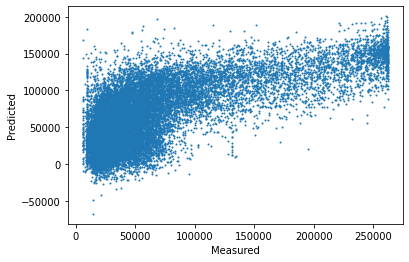

SpearmanrResult(correlation=0.6772517870473369, pvalue=0.0)
Pearson = 0.705821
High Prediction and High Measured Activity 2715 
High Prediction but Low Measured Activity 1909 
Low Prediction and High Measured Activity 807 
All other seqs 16232 
807


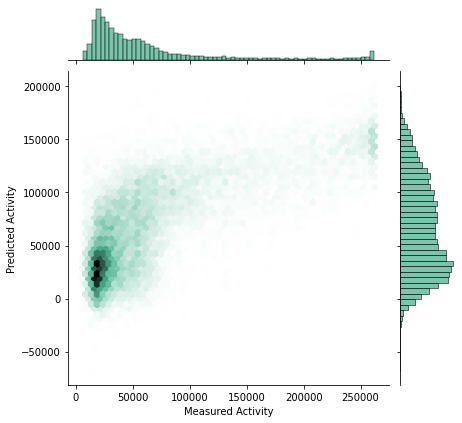

In [11]:
OLS_prediction = model.predict(ANOVA_DF)
plt.scatter(ANOVA_DF.Activity_SCglucose,model.predict(ANOVA_DF),s=1)
plt.xlabel('Measured'),plt.ylabel('Predicted')
plt.show()
spear = scipy.stats.spearmanr(ANOVA_DF.Activity_SCglucose,model.predict(ANOVA_DF))
print(spear)
pear = scipy.stats.pearsonr(ANOVA_DF.Activity_SCglucose,model.predict(ANOVA_DF))
print('Pearson = %f' %pear[0])

import protfasta
sns.jointplot(x=ANOVA_DF.Activity_SCglucose,y=model.predict(ANOVA_DF), kind="hex", color="#4CB391")
plt.xlabel('Measured Activity'), plt.ylabel('Predicted Activity')
plt.savefig('Figures/PaperFigs/ANOVA_OLS20.pdf')
def printCounts():
    indx = (model.predict(ANOVA_DF)>ActivityThreshold)&(ANOVA_DF.Activity_SCglucose>ActivityThreshold)
    print('High Prediction and High Measured Activity %s '%sum(indx))
    tempDF = ANOVA_DF[indx]
    exportfilename = 'ExportedSeqLists/SanjanaMotifEnrichment/OLS_HighPredict_HighMeasured.fasta'
    tempDict = dict(zip(tempDF.Name,tempDF.ADseq))
    protfasta.write_fasta(tempDict,exportfilename)

    indx = (model.predict(ANOVA_DF)>ActivityThreshold)&(ANOVA_DF.Activity_SCglucose<ActivityThreshold)
    print('High Prediction but Low Measured Activity %s '%sum(indx))
    tempDF = ANOVA_DF[indx]
    exportfilename = 'ExportedSeqLists/SanjanaMotifEnrichment/OLS_HighPredict_LowMeasured.fasta'
    tempDict = dict(zip(tempDF.Name,tempDF.ADseq))
    protfasta.write_fasta(tempDict,exportfilename)

    indx = (model.predict(ANOVA_DF)<ActivityThreshold)&(ANOVA_DF.Activity_SCglucose>ActivityThreshold)
    print('Low Prediction and High Measured Activity %s '%sum(indx))
    tempDF = ANOVA_DF[indx]
    exportfilename = 'ExportedSeqLists/SanjanaMotifEnrichment/OLS_LowPredict_HighMeasured.fasta'
    tempDict = dict(zip(tempDF.Name,tempDF.ADseq))
    protfasta.write_fasta(tempDict,exportfilename)

    indx =~((model.predict(ANOVA_DF)>ActivityThreshold)&(ANOVA_DF.Activity_SCglucose>ActivityThreshold))&~((model.predict(ANOVA_DF)>ActivityThreshold)&(ANOVA_DF.Activity_SCglucose>ActivityThreshold))
    print('All other seqs %s '%sum(indx))
    tempDF = ANOVA_DF[indx]
    exportfilename = 'ExportedSeqLists/SanjanaMotifEnrichment/OLS_Background_allOtherSeqs.fasta'
    tempDict = dict(zip(tempDF.Name,tempDF.ADseq))
    protfasta.write_fasta(tempDict,exportfilename)

    indx = (model.predict(ANOVA_DF)<ActivityThreshold)&(ANOVA_DF.Activity_SCglucose>ActivityThreshold)
    print(sum(indx))
printCounts()

In [12]:
sortedDF = aov_table.sort_values(by='sum_sq',ascending=False)
pvalcutoff = .01/model.df_model
sortedDF = sortedDF[sortedDF['PR(>F)']<pvalcutoff]
for row in sortedDF.iterrows():
    print(row.index)
print('There are %i significant parameters'%len(sortedDF))
sortedDF

# formula = 'Activity_SCglucose ~ F + W + D+ M +L+  Y + K +Q +R+I+V+N+A' #Significant coeff only
print(sortedDF.index)
newformula = ''
for i in sortedDF.index:
#     print(i)
    newformula = newformula+i+"+"
print(newformula)

<built-in method index of tuple object at 0x7f9126945300>
<built-in method index of tuple object at 0x7f9124d13ac0>
<built-in method index of tuple object at 0x7f911e944440>
<built-in method index of tuple object at 0x7f912489c800>
<built-in method index of tuple object at 0x7f91248a00c0>
<built-in method index of tuple object at 0x7f9124d13580>
<built-in method index of tuple object at 0x7f9124511b40>
<built-in method index of tuple object at 0x7f9124d13500>
<built-in method index of tuple object at 0x7f9124d0fb80>
<built-in method index of tuple object at 0x7f91248d7f00>
<built-in method index of tuple object at 0x7f9124d13a40>
<built-in method index of tuple object at 0x7f9124d13280>
<built-in method index of tuple object at 0x7f9124d13200>
<built-in method index of tuple object at 0x7f9124d13440>
<built-in method index of tuple object at 0x7f9124d13fc0>
<built-in method index of tuple object at 0x7f912489c500>
There are 16 significant parameters
Index(['F', 'D', 'W', 'M', 'L', 'K',

# Iterative OLS to remove non significant parameters

In [13]:
formula = 'Activity_SCglucose ~ D+F+W+M+L+K+Q+Y+R+I+H+A+C+N+G+T' #Significant coeff only iteration 1

## run ANOVA on all ADs
model = ols(formula, ANOVA_DF).fit()
print( '\n'+ formula)
print(model.summary())
aov_table = anova_lm(model, typ=2)
# print(aov_table)
eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table)
print(model.params)
makeSummaryTableForPaper('Model_2_16SingleAAs')


Activity_SCglucose ~ D+F+W+M+L+K+Q+Y+R+I+H+A+C+N+G+T
                            OLS Regression Results                            
Dep. Variable:     Activity_SCglucose   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     1174.
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:16:32   Log-Likelihood:            -2.2940e+05
No. Observations:               18947   AIC:                         4.588e+05
Df Residuals:                   18930   BIC:                         4.590e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

,Coefficient,Sum of Squares,F,Degrees of Freedom
D,7847.124426,2602922540568.866699,1353.057784,1.0
F,15172.911464,5940814583389.576172,3088.169274,1.0
W,17478.876376,1512366056536.053711,786.161952,1.0
M,8488.210939,1012864612411.444214,526.509847,1.0
L,4030.478155,714811801087.81604,371.57528,1.0
K,-4428.976186,595498355457.142944,309.553462,1.0
Q,-2701.394772,453055320371.565125,235.508363,1.0
Y,5046.411331,320270320251.21582,166.483729,1.0
R,-2521.000125,327922201595.610352,170.461349,1.0
I,1937.708477,86300434260.124863,44.86091,1.0


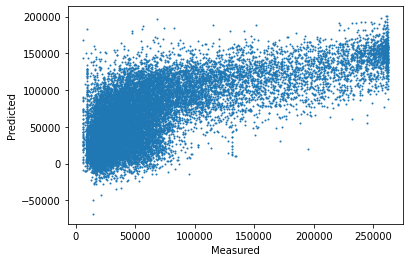

SpearmanrResult(correlation=0.6781225232822574, pvalue=0.0)
Pearson = 0.705755
High Prediction but Low Measured Activity 1898 
High Prediction and High Measured Activity 2715 
All other seqs 16232 
807
<built-in method index of tuple object at 0x7f9124c37b00>
<built-in method index of tuple object at 0x7f9124969880>
<built-in method index of tuple object at 0x7f9124ab2640>
<built-in method index of tuple object at 0x7f9124d85a00>
<built-in method index of tuple object at 0x7f9124c418c0>
<built-in method index of tuple object at 0x7f9124c415c0>
<built-in method index of tuple object at 0x7f9124d14b80>
<built-in method index of tuple object at 0x7f9124c41b00>
<built-in method index of tuple object at 0x7f9124ab3d40>
<built-in method index of tuple object at 0x7f9124ab31c0>
<built-in method index of tuple object at 0x7f9124971840>
<built-in method index of tuple object at 0x7f91248ae480>
<built-in method index of tuple object at 0x7f9124980c00>
<built-in method index of tuple object at 0x

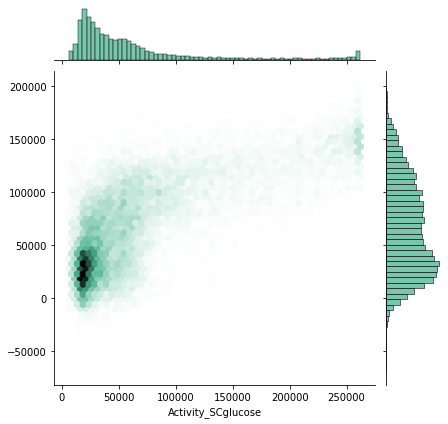

In [14]:
OLS_prediction = model.predict(ANOVA_DF)
plt.scatter(ANOVA_DF.Activity_SCglucose,model.predict(ANOVA_DF),s=1)
plt.xlabel('Measured'),plt.ylabel('Predicted')
plt.show()
spear = scipy.stats.spearmanr(ANOVA_DF.Activity_SCglucose,model.predict(ANOVA_DF))
print(spear)
pear = scipy.stats.pearsonr(ANOVA_DF.Activity_SCglucose,model.predict(ANOVA_DF))
print('Pearson = %f' %pear[0])

import protfasta
sns.jointplot(x=ANOVA_DF.Activity_SCglucose,y=model.predict(ANOVA_DF), kind="hex", color="#4CB391")
indx = (model.predict(ANOVA_DF)>ActivityThreshold)&(ANOVA_DF.Activity_SCglucose<ActivityThreshold)
print('High Prediction but Low Measured Activity %s '%sum(indx))
tempDF = ANOVA_DF[indx]
exportfilename = 'ExportedSeqLists/SanjanaMotifEnrichment/OLS_SignificantParamsOnly_HighPredict_LowMeasured.fasta'
tempDict = dict(zip(tempDF.Name,tempDF.ADseq))
protfasta.write_fasta(tempDict,exportfilename)
indx = (model.predict(ANOVA_DF)>ActivityThreshold)&(ANOVA_DF.Activity_SCglucose>ActivityThreshold)
print('High Prediction and High Measured Activity %s '%sum(indx))
tempDF = ANOVA_DF[indx]
exportfilename = 'ExportedSeqLists/SanjanaMotifEnrichment/OLS_SignificantParamsOnly_HighPredict_HighMeasured.fasta'
tempDict = dict(zip(tempDF.Name,tempDF.ADseq))
protfasta.write_fasta(tempDict,exportfilename)

indx =~((model.predict(ANOVA_DF)>ActivityThreshold)&(ANOVA_DF.Activity_SCglucose>ActivityThreshold))&~((model.predict(ANOVA_DF)>ActivityThreshold)&(ANOVA_DF.Activity_SCglucose>ActivityThreshold))
print('All other seqs %s '%sum(indx))
tempDF = ANOVA_DF[indx]
exportfilename = 'ExportedSeqLists/SanjanaMotifEnrichment/OLS_SignificantParamsOnly_Background_allOtherSeqs.fasta'
tempDict = dict(zip(tempDF.Name,tempDF.ADseq))
protfasta.write_fasta(tempDict,exportfilename)

indx = (model.predict(ANOVA_DF)<ActivityThreshold)&(ANOVA_DF.Activity_SCglucose>ActivityThreshold)
print(sum(indx))

sortedDF = aov_table.sort_values(by='sum_sq',ascending=False)
pvalcutoff = .01/model.df_model
sortedDF = sortedDF[sortedDF['PR(>F)']<pvalcutoff]
for row in sortedDF.iterrows():
    print(row.index)
print('There are %i significant parameters'%len(sortedDF))
sortedDF

printCounts()

#  ANOVA models with enriched motifs

In [15]:
# # These motifs were enriched in top seqs.
# # EnrichedMotifs = ['MF','FS','SL','DI','LF','LD','PW','GD','YP','SG','FP','SA','YN','LL','LT','EE','IY','NE','TS','AL',
# #                   'FSL','DEL','SLF','FDL','PMF',
# #                   'TPMF','FDEL', 'MFDE','DELD', 'ELDF',
# #                   'FDELD','DELDF','MFDEL']
# # here is a longer set of motifs that were enriched or deplected in top or bottoms sequences (N=200) with 'composition sufficient for activity'
# EnrichedMotifs = ['MF','FS','SL','DI','LF','LD','PW','GD','YP','SG','FP','SA','YN','LL','LT','EE','IY','NE','TS','AL',
#                  'WPD','SAP','WYP','PWY','FDV',
#                   'FSL','DEL','SLF','FDL','PMF',
#                   'SPS','PNS','SAL','ASP','SSA','VSE','STY','SEH','SIY','TAL','LTS','IPM','NES','YNE','EHL','DFN','ALT','LPE','PLL','IYN','EEE','LLP','MSA',
#                  ]

# # look at dipeptides
# dipeptides = []
# for motif in EnrichedMotifs:
#     ANOVA_DF[motif]= ANOVA_DF.apply(lambda row: row['ADseq'].count(motif),axis=1) 

# # formula =Activity+' ~'
# formula = 'Activity_SCglucose ~ D + W + F+ Y + M + L + E + K + R +A+P+G+S+G+Q+N+I+V'
# for motif in EnrichedMotifs:
#     formula = formula+' + '+motif
# formula


# print(formula)
# model = ols(formula, ANOVA_DF).fit()

# print(model.summary())
# aov_table = anova_lm(model, typ=2)
# eta_squared(aov_table)
# omega_squared(aov_table)
# print(aov_table)

# Dipeptides
rerun 20220823 w. deeper seq data

In [16]:
# look at dipeptides
dipeptides = []
# AAs = ['D','E','W','F','Y','L','M','K','R']
AAs = allAAs
for p1 in AAs:
    for p2 in AAs:
        dipeptides.append(p1+p2)
print( dipeptides)
for dipep in dipeptides:
    ANOVA_DF[dipep]= ANOVA_DF.apply(lambda row: row['ADseq'].count(dipep),axis=1) 

formula =Activity+' ~'
for dipep in dipeptides:
    formula = formula+' + '+dipep
formula


# print(formula)
# model = ols(formula, ANOVA_DF).fit()

# print(model.summary())
# aov_table = anova_lm(model, typ=2)
# eta_squared(aov_table)
# omega_squared(aov_table)
# print(aov_table)

['AA', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AK', 'AL', 'AM', 'AN', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AV', 'AW', 'AY', 'CA', 'CC', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CK', 'CL', 'CM', 'CN', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CV', 'CW', 'CY', 'DA', 'DC', 'DD', 'DE', 'DF', 'DG', 'DH', 'DI', 'DK', 'DL', 'DM', 'DN', 'DP', 'DQ', 'DR', 'DS', 'DT', 'DV', 'DW', 'DY', 'EA', 'EC', 'ED', 'EE', 'EF', 'EG', 'EH', 'EI', 'EK', 'EL', 'EM', 'EN', 'EP', 'EQ', 'ER', 'ES', 'ET', 'EV', 'EW', 'EY', 'FA', 'FC', 'FD', 'FE', 'FF', 'FG', 'FH', 'FI', 'FK', 'FL', 'FM', 'FN', 'FP', 'FQ', 'FR', 'FS', 'FT', 'FV', 'FW', 'FY', 'GA', 'GC', 'GD', 'GE', 'GF', 'GG', 'GH', 'GI', 'GK', 'GL', 'GM', 'GN', 'GP', 'GQ', 'GR', 'GS', 'GT', 'GV', 'GW', 'GY', 'HA', 'HC', 'HD', 'HE', 'HF', 'HG', 'HH', 'HI', 'HK', 'HL', 'HM', 'HN', 'HP', 'HQ', 'HR', 'HS', 'HT', 'HV', 'HW', 'HY', 'IA', 'IC', 'ID', 'IE', 'IF', 'IG', 'IH', 'II', 'IK', 'IL', 'IM', 'IN', 'IP', 'IQ', 'IR', 'IS', 'IT', 'IV', 'IW', 'IY', 'KA', 'KC', 'KD', 'KE', 'KF', 'KG', 'KH

'Activity_SCglucose ~ + AA + AC + AD + AE + AF + AG + AH + AI + AK + AL + AM + AN + AP + AQ + AR + AS + AT + AV + AW + AY + CA + CC + CD + CE + CF + CG + CH + CI + CK + CL + CM + CN + CP + CQ + CR + CS + CT + CV + CW + CY + DA + DC + DD + DE + DF + DG + DH + DI + DK + DL + DM + DN + DP + DQ + DR + DS + DT + DV + DW + DY + EA + EC + ED + EE + EF + EG + EH + EI + EK + EL + EM + EN + EP + EQ + ER + ES + ET + EV + EW + EY + FA + FC + FD + FE + FF + FG + FH + FI + FK + FL + FM + FN + FP + FQ + FR + FS + FT + FV + FW + FY + GA + GC + GD + GE + GF + GG + GH + GI + GK + GL + GM + GN + GP + GQ + GR + GS + GT + GV + GW + GY + HA + HC + HD + HE + HF + HG + HH + HI + HK + HL + HM + HN + HP + HQ + HR + HS + HT + HV + HW + HY + IA + IC + ID + IE + IF + IG + IH + II + IK + IL + IM + IN + IP + IQ + IR + IS + IT + IV + IW + IY + KA + KC + KD + KE + KF + KG + KH + KI + KK + KL + KM + KN + KP + KQ + KR + KS + KT + KV + KW + KY + LA + LC + LD + LE + LF + LG + LH + LI + LK + LL + LM + LN + LP + LQ + LR + L

In [17]:
# print(formula)
model = ols(formula, ANOVA_DF).fit()

print(model.summary())
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table)
makeSummaryTableForPaper('Model_3_400Dipeptides')

                            OLS Regression Results                            
Dep. Variable:     Activity_SCglucose   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     89.54
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:18:26   Log-Likelihood:            -2.2574e+05
No. Observations:               18947   AIC:                         4.523e+05
Df Residuals:                   18546   BIC:                         4.554e+05
Df Model:                         400                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.056e+04   1.84e+04     -2.755      0.0

,Coefficient,Sum of Squares,F,Degrees of Freedom
AA,3979.854467,34609319991.268311,25.930704,1.0
AC,1515.665502,199076533.401696,0.149156,1.0
AD,-5134.180182,18645801946.456909,13.97019,1.0
AE,-7343.611277,32458876209.819656,24.319505,1.0
AF,12344.149829,97740922112.457047,73.231458,1.0
...,...,...,...,...
YV,-6826.141511,6611449110.773082,4.953565,1.0
YW,6973.573953,3247823194.22157,2.433401,1.0
YY,5869.183121,3199095812.974061,2.396892,1.0
Residual,NaN,24753066493434.054688,NaN,18546.0


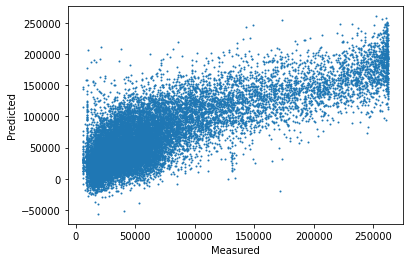

SpearmanrResult(correlation=0.7277646921923017, pvalue=0.0)
Pearson = 0.811689
1390
2938
All other seqs 16009 
584


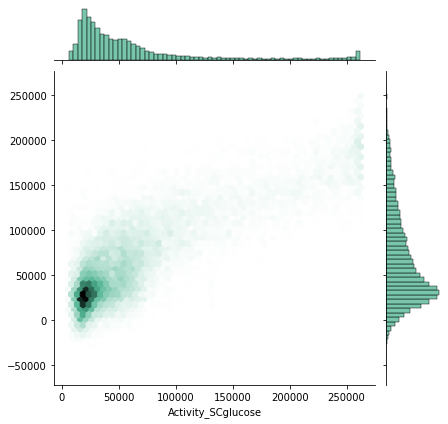

In [18]:
OLS_prediction = model.predict(ANOVA_DF)
plt.scatter(ANOVA_DF.Activity_SCglucose,model.predict(ANOVA_DF),s=1)
plt.xlabel('Measured'),plt.ylabel('Predicted')
plt.show()
spear = scipy.stats.spearmanr(ANOVA_DF.Activity_SCglucose,model.predict(ANOVA_DF))
print(spear)
pear = scipy.stats.pearsonr(ANOVA_DF.Activity_SCglucose,model.predict(ANOVA_DF))
print('Pearson = %f' %pear[0])

import protfasta
sns.jointplot(x=ANOVA_DF.Activity_SCglucose,y=model.predict(ANOVA_DF), kind="hex", color="#4CB391")
indx = (model.predict(ANOVA_DF)>ActivityThreshold)&(ANOVA_DF.Activity_SCglucose<ActivityThreshold)
print(sum(indx))
tempDF = ANOVA_DF[indx]
exportfilename = 'ExportedSeqLists/SanjanaMotifEnrichment/Dipeptides_HighPredict_LowMeasured.fasta'
tempDict = dict(zip(tempDF.Name,tempDF.ADseq))
protfasta.write_fasta(tempDict,exportfilename)
indx = (model.predict(ANOVA_DF)>ActivityThreshold)&(ANOVA_DF.Activity_SCglucose>ActivityThreshold)
print(sum(indx))
tempDF = ANOVA_DF[indx]
exportfilename = 'ExportedSeqLists/SanjanaMotifEnrichment/Dipeptides_HighPredict_HighMeasured.fasta'
tempDict = dict(zip(tempDF.Name,tempDF.ADseq))
protfasta.write_fasta(tempDict,exportfilename)

indx =~((model.predict(ANOVA_DF)>ActivityThreshold)&(ANOVA_DF.Activity_SCglucose>ActivityThreshold))&~((model.predict(ANOVA_DF)>ActivityThreshold)&(ANOVA_DF.Activity_SCglucose>ActivityThreshold))
print('All other seqs %s '%sum(indx))
tempDF = ANOVA_DF[indx]
exportfilename = 'ExportedSeqLists/SanjanaMotifEnrichment/Dipeptides_Background_allOtherSeqs.fasta'
tempDict = dict(zip(tempDF.Name,tempDF.ADseq))
protfasta.write_fasta(tempDict,exportfilename)


indx = (model.predict(ANOVA_DF)<ActivityThreshold)&(ANOVA_DF.Activity_SCglucose>ActivityThreshold)
print(sum(indx))

In [19]:
sortedDF = aov_table.sort_values(by='sum_sq',ascending=False)
pvalcutoff = .01/400
sortedDF = sortedDF[sortedDF['PR(>F)']<pvalcutoff]
print('There are %i significant parameters'%len(sortedDF))

Round2parameters = list(sortedDF.index)

formula =Activity+' ~'
for dipep in Round2parameters:
    formula = formula+' + '+dipep
formula


print(formula)
model = ols(formula, ANOVA_DF).fit()

printCounts()
print(model.summary())


There are 79 significant parameters
Activity_SCglucose ~ + LF + DW + EF + EW + WF + DF + DL + MF + PF + FF + DA + SF + DI + QF + EL + TF + NW + IF + DY + AF + WY + LG + QW + LD + FD + NF + SL + YM + GF + IK + FK + WH + VF + TV + MD + PM + PL + VK + PY + LM + RA + HW + DP + LA + HF + CF + AK + QK + AA + KV + RH + AE + FR + FM + RR + DM + MG + KR + IS + WD + MM + EP + TW + DG + GV + LW + IA + SV + GL + ML + KH + RV + SA + EA + PI + AY + TI + GK + QI
High Prediction and High Measured Activity 2848 
High Prediction but Low Measured Activity 1439 
Low Prediction and High Measured Activity 674 
All other seqs 16099 
674
                            OLS Regression Results                            
Dep. Variable:     Activity_SCglucose   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     372.3
Date:                Tue, 05 Nov 2024   Prob (F-statistic):   

In [24]:
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table)
sortedDF = aov_table.sort_values(by='sum_sq',ascending=False)
pvalcutoff = .01/400
sortedDF = sortedDF[sortedDF['PR(>F)']<pvalcutoff]
print('There are %i significant parameters'%len(sortedDF))

Round2parameters = list(sortedDF.index)

formula =Activity+' ~'
for dipep in Round2parameters:
    formula = formula+' + '+dipep
formula


print(formula)
model = ols(formula, ANOVA_DF).fit()

printCounts()
print(model.summary())


                sum_sq       df            F         PR(>F)    eta_sq  \
LF        2.293630e+12      1.0  1518.853831  1.288079e-319  0.048338   
DL        1.301489e+12      1.0   861.852717  2.760497e-185  0.027428   
WF        1.106583e+12      1.0   732.785132  2.320940e-158  0.023321   
DF        1.018689e+12      1.0   674.581187  3.694577e-146  0.021469   
EW        8.455033e+11      1.0   559.896802  5.267199e-122  0.017819   
...                ...      ...          ...            ...       ...   
GL        4.007992e+10      1.0    26.541140   2.605814e-07  0.000845   
ML        3.282949e+10      1.0    21.739864   3.143721e-06  0.000692   
KH        3.166992e+10      1.0    20.971993   4.690233e-06  0.000667   
LA        2.212183e+10      1.0    14.649196   1.299075e-04  0.000466   
Residual  2.850626e+13  18877.0          NaN            NaN       NaN   

          omega_sq  
LF        0.048304  
DL        0.027396  
WF        0.023288  
DF        0.021436  
EW        0.017786

In [25]:

makeSummaryTableForPaper('Model_4_69Dipeptides')

,Coefficient,Sum of Squares,F,Degrees of Freedom
LF,26249.636776,2293629610344.668457,1518.853831,1.0
DL,17813.049445,1301488577805.051025,861.852717,1.0
WF,43120.506067,1106582900951.002197,732.785132,1.0
DF,17236.435405,1018688798953.021606,674.581187,1.0
EW,46604.971157,845503271697.052368,559.896802,1.0
...,...,...,...,...
ML,7228.049814,32829488745.374359,21.739864,1.0
KH,7204.630490,31669922748.771957,20.971993,1.0
LA,NaN,22121831704.049534,14.649196,1.0
Residual,NaN,28506262606982.296875,NaN,18877.0


# ANOVA on published Motifs

In [29]:

def CountMotifs(currentDF, motiflist,column='ADseq'):
    for motif in motiflist:
        tempcol = []
        for seq in currentDF[column]:
            hits = re.search(motif,seq)
            if hits:
                matches = re.findall(motif,seq)
                tempcol.append(len(matches))
            else:
                tempcol.append(0)
        currentDF[motif]=tempcol
    return currentDF
motiflist_publication = ['W..LF','[WFYL]..[WFYL][WFYL]','[DE][WFY]','FF','F.F','F..F', 'MF.Y..L'    ]
masterDF = CountMotifs(masterDF,motiflist_publication)

ANOVA_DF = masterDF[[Activity,'ADseq','Name']]
dataCols = motiflist_publication +allAAs

# add back the data from other columns
tempSeries = ANOVA_DF.ADseq
Cols2Add = dataCols
for col in Cols2Add:
    tempDict = dict(zip(masterDF.ADseq,masterDF[col]))
    ANOVA_DF[col] = tempSeries.map(tempDict)
ANOVA_DF =ANOVA_DF.rename(columns={'W..LF':'WxxLF','[WFYL]..[WFYL][WFYL]':'PhixxPhiPhi',
                                   '[DE][WFY]':'DE_WFY','F.F':'FxF','F..F':'FxxF','MF.Y..L':'MFxYxxL'})
print(ANOVA_DF.columns)
formula = 'Activity_SCglucose ~ WxxLF +PhixxPhiPhi + DE_WFY + FF + FxF + FxxF + MFxYxxL'
# formula = 'Activity_SCglucose ~ WxxLF +PhixxPhiPhi + DE_WFY + FF + FxF + FxxF + MFxYxxL+A + C + D + E + F + G + H + I + K + L + M + N + P + Q + R + S + T + V + W + Y'





## run ANOVA on all ADs
model = ols(formula, ANOVA_DF).fit()
print( '\n'+ formula)
print(model.summary())
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table)
# masterDF.columns
makeSummaryTableForPaper('Model_5_PublishedMotifs')

Index(['Activity_SCglucose', 'ADseq', 'Name', 'WxxLF', 'PhixxPhiPhi', 'DE_WFY',
       'FF', 'FxF', 'FxxF', 'MFxYxxL', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
       'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'],
      dtype='object')

Activity_SCglucose ~ WxxLF +PhixxPhiPhi + DE_WFY + FF + FxF + FxxF + MFxYxxL
                            OLS Regression Results                            
Dep. Variable:     Activity_SCglucose   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     1355.
Date:                Wed, 02 Oct 2024   Prob (F-statistic):               0.00
Time:                        09:47:25   Log-Likelihood:            -2.3208e+05
No. Observations:               18947   AIC:                         4.642e+05
Df Residuals:                   18939   BIC:                         4.642e+05
Df Model:                           7    

,Coefficient,Sum of Squares,F,Degrees of Freedom
WxxLF,76541.141992,4344190532123.089844,1702.000107,1.0
PhixxPhiPhi,9300.294535,104418729594.15625,40.909966,1.0
DE_WFY,28757.790390,5285768320609.538086,2070.898635,1.0
FF,27016.665126,491126031105.369324,192.417103,1.0
FxF,14455.070759,141989708383.415588,55.629811,1.0
FxxF,-197.671521,83996792.196014,0.032909,1.0
MFxYxxL,-824.702170,29268937.43946,0.011467,1.0
Residual,NaN,48339964357884.421875,NaN,18939.0
Intercept,43900.457457,,,


In [30]:
#ANOVA on Sanjana's de novo motifs
files =[
    'ExportedSeqLists/SanjanaMotifEnrichment/STREME_MotifCounts/STREME_active_vs_inactive_motif_counts_19K_seqs.csv',
#        'ExportedSeqLists/SanjanaMotifEnrichment/STREME_MotifCounts/STREME_ols_motif_counts_19K_seqs.csv',
#        'ExportedSeqLists/SanjanaMotifEnrichment/STREME_MotifCounts/STREME_ols_sig_params_motif_counts_19K_seqs.csv',
#     'ExportedSeqLists/SanjanaMotifEnrichment/STREME_MotifCounts/STREME_dipeptides_motif_counts_19K_seqs.csv',
    ]
includeAllAAs = False

for file in files:
    print('\n\n')
    print('-'*100)
    print(file)
    tempSKDF = pd.read_csv(file)
    # for each column, rename it
    colRenameDict ={}
    for col in tempSKDF.columns:
        if '_' in col:
            colRenameDict[col]=col.split('_')[1]
    tempSKDF = tempSKDF.rename(columns=colRenameDict)
    tempSeries = tempSKDF.seq
    if includeAllAAs ==True:
        for col in allAAs:
            tempDict = dict(zip(masterDF.ADseq,masterDF[col]))
            tempSKDF[col] = tempSeries.map(tempDict)
    tempDict = dict(zip(masterDF.ADseq,masterDF[Activity]))
    tempSKDF[Activity] = tempSeries.map(tempDict)

    formula = 'Activity_SCglucose ~ '
#     formula = 'Activity_SCglucose ~ A + C + D + E + F + G + H + I + K + L + M + N + P + Q + R + S + T + V + W + Y +'#20AAs

    for col in tempSKDF.columns[3:-1]:
        formula = formula+col+' + '
    formula = formula[:-3]
    formula
    # run ANOVA on all ADs
    model = ols(formula, tempSKDF).fit()
    print( '\n'+ formula)
    print(model.summary())
    aov_table = anova_lm(model, typ=2)
    eta_squared(aov_table)
    omega_squared(aov_table)
    print(aov_table)

makeSummaryTableForPaper('Model_6_DeNovoMotifs')





----------------------------------------------------------------------------------------------------
ExportedSeqLists/SanjanaMotifEnrichment/STREME_MotifCounts/STREME_active_vs_inactive_motif_counts_19K_seqs.csv

Activity_SCglucose ~ FDTSPMFG + DASAPPSASF + FDPEADFE + EPTMNSSN + FSSPQFTA + SSSTSNLG + NSTALTAL + YENLEDNSK + AYSSPAVP + IHDPSIDL + VDAFFSSS + DWFSLFPD + GLQSDYSPLT + DNELAPGH + SSSSIGSL + PNMAMQDMD + MSPFLDDDSS + NYHNSTPMST + FAGDAVMASD + TSPSLYESP + PDIDQSPFI + HDFNTAVP + DLDLALAG + DGFAAALDT + DPWYPLFP + DWETWSGA + EHFDFGAF + TTINDPMSA + DLSTNQFIDDFEVSA + MKIVDPDIWGEDLW + PASMDSPLAFHDLGL + SGDFDTGSN + VFSGNFSAA + TVSPQDLF + HSDLENPD + GLGAVTDP + HEPFMSAP + LFDDFTAF + PDNLFDLP + PSFDSPGY + EGGASTTN
                            OLS Regression Results                            
Dep. Variable:     Activity_SCglucose   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares  

,Coefficient,Sum of Squares,F,Degrees of Freedom
FDTSPMFG,45850.927244,2729511892350.890137,1433.195695,1.0
DASAPPSASF,3902.525522,16895166925.105541,8.871213,1.0
FDPEADFE,40913.628376,567056638644.374878,297.746691,1.0
EPTMNSSN,50559.373426,734327145687.307251,385.576083,1.0
FSSPQFTA,8890.431140,61559412234.823051,32.323246,1.0
SSSTSNLG,-5473.208399,37428535474.811172,19.65275,1.0
NSTALTAL,-17246.490339,182433961907.763275,95.791328,1.0
YENLEDNSK,132.936686,3367720.338889,0.001768,1.0
AYSSPAVP,-4832.390608,18031017262.767677,9.467618,1.0
IHDPSIDL,30794.016511,194246912742.941864,101.994001,1.0


In [31]:
sortedDF = aov_table.sort_values(by='sum_sq',ascending=False)
pvalcutoff = .01/len(sortedDF)
sortedDF = sortedDF[sortedDF['PR(>F)']<pvalcutoff]
print('There are %i significant parameters'%len(sortedDF))

Round2parameters = list(sortedDF.index)

formula =Activity+' ~'
for dipep in Round2parameters:
    formula = formula+' + '+dipep
formula


print(formula)
model = ols(formula, tempSKDF).fit()
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table)

# printCounts()
print(model.summary())
makeSummaryTableForPaper('Model_7_denovoMotifs_Reduced')

There are 27 significant parameters
Activity_SCglucose ~ + TVSPQDLF + FDTSPMFG + LFDDFTAF + DLDLALAG + EPTMNSSN + PDNLFDLP + DWFSLFPD + FDPEADFE + VDAFFSSS + GLQSDYSPLT + DPWYPLFP + MKIVDPDIWGEDLW + DWETWSGA + IHDPSIDL + TSPSLYESP + NSTALTAL + EGGASTTN + FAGDAVMASD + PASMDSPLAFHDLGL + NYHNSTPMST + VFSGNFSAA + FSSPQFTA + HEPFMSAP + PDIDQSPFI + HDFNTAVP + EHFDFGAF + SSSTSNLG
                       sum_sq       df            F         PR(>F)    eta_sq  \
TVSPQDLF         3.437780e+12      1.0  1797.159153   0.000000e+00  0.066973   
FDTSPMFG         3.094772e+12      1.0  1617.845652   0.000000e+00  0.060291   
LFDDFTAF         1.818563e+12      1.0   950.685066  1.027530e-203  0.035428   
DLDLALAG         1.172405e+12      1.0   612.895035  3.464887e-133  0.022840   
EPTMNSSN         7.531628e+11      1.0   393.728859   9.761217e-87  0.014673   
PDNLFDLP         8.510510e+11      1.0   444.901628   1.238711e-97  0.016580   
DWFSLFPD         6.372883e+11      1.0   333.153495   8.518394e-

,Coefficient,Sum of Squares,F,Degrees of Freedom
TVSPQDLF,56670.126172,3437780420048.067383,1797.159153,1.0
FDTSPMFG,46099.925919,3094772155432.231445,1617.845652,1.0
LFDDFTAF,40862.604421,1818562646473.350586,950.685066,1.0
DLDLALAG,39974.925908,1172405096795.380859,612.895035,1.0
EPTMNSSN,50181.358840,753162769008.097046,393.728859,1.0
PDNLFDLP,31191.300533,851051006516.056152,444.901628,1.0
DWFSLFPD,30157.557069,637288334639.331055,333.153495,1.0
FDPEADFE,41203.803657,584151597204.819214,305.375347,1.0
VDAFFSSS,29139.750926,342093601666.821838,178.835345,1.0
GLQSDYSPLT,38105.320127,309855692088.310059,161.98242,1.0


In [32]:
#ANOVA on Sanjana's de novo motifs and single AAs
files =[
    'ExportedSeqLists/SanjanaMotifEnrichment/STREME_MotifCounts/STREME_active_vs_inactive_motif_counts_19K_seqs.csv',
#        'ExportedSeqLists/SanjanaMotifEnrichment/STREME_MotifCounts/STREME_ols_motif_counts_19K_seqs.csv',
#        'ExportedSeqLists/SanjanaMotifEnrichment/STREME_MotifCounts/STREME_ols_sig_params_motif_counts_19K_seqs.csv',
#     'ExportedSeqLists/SanjanaMotifEnrichment/STREME_MotifCounts/STREME_dipeptides_motif_counts_19K_seqs.csv',
    ]
includeAllAAs = True

for file in files:
    print('\n\n')
    print('-'*100)
    print(file)
    tempSKDF = pd.read_csv(file)
    # for each column, rename it
    colRenameDict ={}
    for col in tempSKDF.columns:
        if '_' in col:
            colRenameDict[col]=col.split('_')[1]
    tempSKDF = tempSKDF.rename(columns=colRenameDict)
    tempSeries = tempSKDF.seq
    if includeAllAAs ==True:
        for col in allAAs:
            tempDict = dict(zip(masterDF.ADseq,masterDF[col]))
            tempSKDF[col] = tempSeries.map(tempDict)
    tempDict = dict(zip(masterDF.ADseq,masterDF[Activity]))
    tempSKDF[Activity] = tempSeries.map(tempDict)

    formula = 'Activity_SCglucose ~ '
#     formula = 'Activity_SCglucose ~ A + C + D + E + F + G + H + I + K + L + M + N + P + Q + R + S + T + V + W + Y +'#20AAs

    for col in tempSKDF.columns[3:-1]:
        formula = formula+col+' + '
    formula = formula[:-3]
    formula
    # run ANOVA on all ADs
    model = ols(formula, tempSKDF).fit()
    print( '\n'+ formula)
    print(model.summary())
    aov_table = anova_lm(model, typ=2)
    eta_squared(aov_table)
    omega_squared(aov_table)
    print(aov_table)

makeSummaryTableForPaper('Model_8_DeNovoMotifsAndSingleAAs')





----------------------------------------------------------------------------------------------------
ExportedSeqLists/SanjanaMotifEnrichment/STREME_MotifCounts/STREME_active_vs_inactive_motif_counts_19K_seqs.csv

Activity_SCglucose ~ FDTSPMFG + DASAPPSASF + FDPEADFE + EPTMNSSN + FSSPQFTA + SSSTSNLG + NSTALTAL + YENLEDNSK + AYSSPAVP + IHDPSIDL + VDAFFSSS + DWFSLFPD + GLQSDYSPLT + DNELAPGH + SSSSIGSL + PNMAMQDMD + MSPFLDDDSS + NYHNSTPMST + FAGDAVMASD + TSPSLYESP + PDIDQSPFI + HDFNTAVP + DLDLALAG + DGFAAALDT + DPWYPLFP + DWETWSGA + EHFDFGAF + TTINDPMSA + DLSTNQFIDDFEVSA + MKIVDPDIWGEDLW + PASMDSPLAFHDLGL + SGDFDTGSN + VFSGNFSAA + TVSPQDLF + HSDLENPD + GLGAVTDP + HEPFMSAP + LFDDFTAF + PDNLFDLP + PSFDSPGY + EGGASTTN + A + C + D + E + F + G + H + I + K + L + M + N + P + Q + R + S + T + V + W + Y
                            OLS Regression Results                            
Dep. Variable:     Activity_SCglucose   R-squared:                       0.608
Model:                            OLS 

,Coefficient,Sum of Squares,F,Degrees of Freedom
FDTSPMFG,28609.572920,957893525671.079956,635.949828,1.0
DASAPPSASF,4268.494933,19199428907.987236,12.746587,1.0
FDPEADFE,26043.042109,222133450593.637146,147.475399,1.0
EPTMNSSN,30584.404676,252031870475.29837,167.325095,1.0
FSSPQFTA,3567.961685,9714742481.804298,6.449661,1.0
...,...,...,...,...
V,1993.576123,129127512403.015961,85.728337,1.0
W,11879.605733,563929470673.354126,374.395317,1.0
Y,5004.867582,289734608475.173096,192.356112,1.0
Residual,NaN,28400168736972.726562,NaN,18855.0


In [33]:
sortedDF = aov_table.sort_values(by='sum_sq',ascending=False)
pvalcutoff = .01/len(sortedDF)
sortedDF = sortedDF[sortedDF['PR(>F)']<pvalcutoff]
print('There are %i significant parameters'%len(sortedDF))

Round2parameters = list(sortedDF.index)

formula =Activity+' ~'
for dipep in Round2parameters:
    formula = formula+' + '+dipep
formula


print(formula)
model = ols(formula, tempSKDF).fit()
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table)
# printCounts()
print(model.summary())
makeSummaryTableForPaper('Model_9_DeNovoMotifsAndSingleAAs_Reduced')


There are 37 significant parameters
Activity_SCglucose ~ + F + TVSPQDLF + FDTSPMFG + L + W + LFDDFTAF + M + DLDLALAG + D + I + PDNLFDLP + Y + DWFSLFPD + EPTMNSSN + FDPEADFE + NSTALTAL + DPWYPLFP + GLQSDYSPLT + K + Q + V + VDAFFSSS + DWETWSGA + IHDPSIDL + MKIVDPDIWGEDLW + P + FAGDAVMASD + TSPSLYESP + SSSTSNLG + A + NYHNSTPMST + PASMDSPLAFHDLGL + E + HSDLENPD + N + EHFDFGAF + PSFDSPGY
                       sum_sq       df            F         PR(>F)    eta_sq  \
F                3.678996e+12      1.0  2427.851026   0.000000e+00  0.086450   
TVSPQDLF         2.661718e+12      1.0  1756.527061   0.000000e+00  0.062546   
FDTSPMFG         1.092821e+12      1.0   721.176566  6.253628e-156  0.025679   
L                5.747991e+11      1.0   379.322726   1.157025e-83  0.013507   
W                5.844741e+11      1.0   385.707456   5.022462e-85  0.013734   
LFDDFTAF         5.838484e+11      1.0   385.294540   6.151948e-85  0.013719   
M                5.320433e+11      1.0   351.107206   

,Coefficient,Sum of Squares,F,Degrees of Freedom
F,12557.428429,3678995553245.586914,2427.851026,1.0
TVSPQDLF,49304.048814,2661718192957.447754,1756.527061,1.0
FDTSPMFG,27996.504911,1092820502714.022705,721.176566,1.0
L,3741.900812,574799115153.188477,379.322726,1.0
W,11785.742041,584474088818.590576,385.707456,1.0
LFDDFTAF,23201.068716,583848384764.81665,385.29454,1.0
M,6534.369804,532043291081.699463,351.107206,1.0
DLDLALAG,30056.092660,644482173277.22168,425.308126,1.0
D,3150.580687,363500140140.782227,239.881831,1.0
I,3884.674924,303766667183.341797,200.462383,1.0
